<a href="https://colab.research.google.com/github/bailejor/SAMSHA_Transfer_Learning/blob/main/Methadone_othersub_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer from General Substance Dataset**

In this model transfer learning is implemented on a CNN model built from scratch. The weights from the CNN in experiment 1 are retained. This model was trained on the general substance dataset (training and validation n = 435,974, test n = 93,728) and then transfer learning occurs after replacing the sigmoid layer at the top of the model and allowing it to be trainable.

The methadone dataset is small (10% of all medication-assisted opioid treatment from 2018, n = 16,731). It is meant to mimic clinical records that a treatment center in a large city would have access to. 

In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Activation, Flatten, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image_dataset_from_directory
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, roc_auc_score, fbeta_score, precision_recall_curve, precision_score, recall_score, f1_score
from matplotlib import pyplot


Load two methadone datasets each with 5% of all methadone treatments


In [ ]:
!unzip /content/drive/MyDrive/MethImages5Val.nosync.zip

In [ ]:
!unzip /content/drive/MyDrive/MethImages5Test.nosync.zip

Found 8365 files belonging to 2 classes.
Using 5856 files for training.
Found 8365 files belonging to 2 classes.
Using 2509 files for validation.


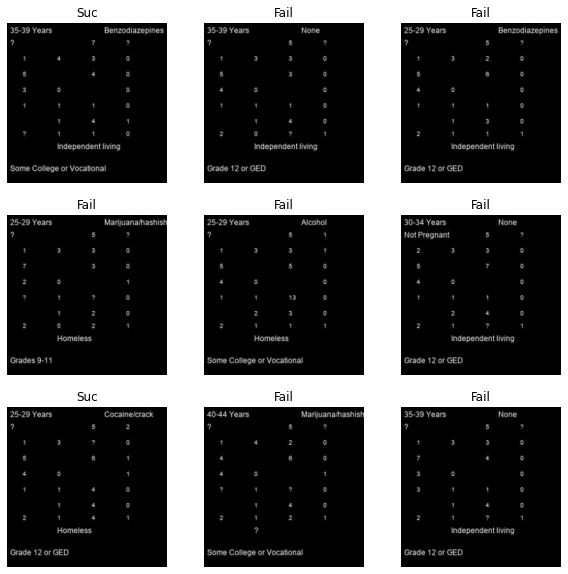

In [2]:
train_dataset_meth = image_dataset_from_directory(
    '/content/MethImages5Val.nosync',
    validation_split=0.3,
    subset="training",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)

validation_dataset_meth = image_dataset_from_directory(
    '/content/MethImages5Val.nosync',
    validation_split=0.3,
    subset="validation",
    seed=6,
    image_size=(250, 250),
    batch_size=32,
    shuffle = True,
    color_mode = 'rgb'
)



class_names = train_dataset_meth.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset_meth.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+ 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [3]:
#Load model from experiment 1 with weights

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))





In [5]:


model_new = Sequential()
model.trainable = False
#Copy the trained model
for layer in model.layers[:-1]:
  model_new.add(layer)

model_new.load_weights('/content/drive/MyDrive/best_model_noweight.h5')
#Add in new activation layer
model_new.add(Activation('sigmoid'))
model_new.layers[-1].trainable = True
#model_new.layers[18].trainable = True

#For some reason this layer was set to trainable despite making the whole model untrainable
model_new.layers[0].trainable = False
#model_new.trainable = True
#model_new.summary()
for layer in model_new.layers: print(layer, layer.trainable)          

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
ModelCheckpoint(filepath='/content/drive/MyDrive/best_methadone_model.h5', monitor='val_loss', save_best_only=True)]

#Recompile with all layers trainable and low learning rate
model_new.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True), optimizer = keras.optimizers.Adam(),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.BinaryAccuracy(), keras.metrics.TruePositives(), keras.metrics.TrueNegatives(), keras.metrics.FalseNegatives(), keras.metrics.FalsePositives()])



model_new.fit(train_dataset_meth, epochs = 15, verbose = 1, validation_data = validation_dataset_meth, callbacks = callbacks)

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7fa417f790> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7fe0036150> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7fa4098c10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7fa4098dd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7fa4098a10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7fa40aaf50> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7f7fa40b9250> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7fa40b9d90> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7fa40b0e50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7fa4098590> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7fa40b5150> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7fa40b5e50> False
<tensorf

In [6]:
test_dataset = image_dataset_from_directory('/content/MethImages5Test.nosync', image_size=(250, 250), color_mode='rgb', shuffle=False, labels = 'inferred', label_mode = 'binary')

Found 8366 files belonging to 2 classes.


0.5285611338834366
0.808869232608176
[[6665   25]
 [1574  102]]
0.8031496062992126
0.060859188544152745
0.11314475873544093
0.2335164835164835


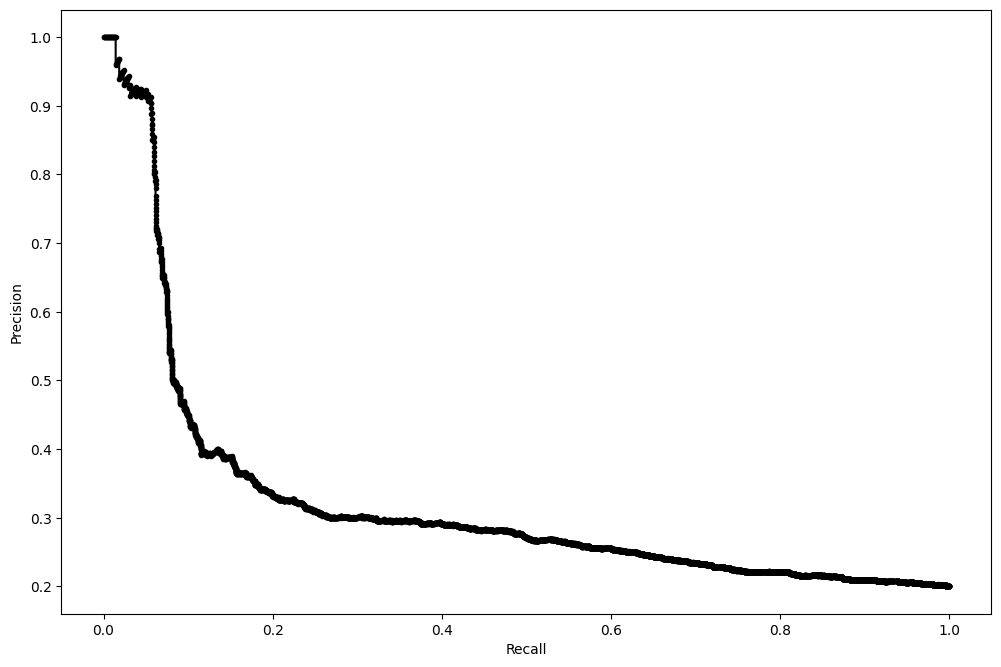

In [7]:
model_new.load_weights('/content/drive/MyDrive/best_methadone_model.h5')

test_labels = []
test_classes = test_dataset.class_names
for images, labels in test_dataset:
  test_labels.append(labels)
test_labels = np.concatenate(test_labels, axis=0 )
test_labels = test_labels.flatten()


pred = model_new.predict(test_dataset)
pred = pred.flatten()

precision, recall, thresholds = precision_recall_curve(test_labels, pred)

pyplot.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
pyplot.plot(recall, precision, marker='.', label='Transfer Learning', color = 'k')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')



pred[pred<0.5]=0
pred[pred>=0.5]=1



print(balanced_accuracy_score(test_labels, pred))

print(accuracy_score(test_labels, pred))
print(confusion_matrix(test_labels, pred))
print(precision_score(test_labels, pred))
print(recall_score(test_labels, pred))
print(f1_score(test_labels, pred))
print(fbeta_score(test_labels, pred, beta = 0.5))